<a href="https://colab.research.google.com/github/Sahel-Eskandar/Project-Notebooks/blob/main/3_nonEEG_Psychological_State_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --target=$nb_path hmmlearn --upgrade
#!pip install --target=$nb_path hyperopt --upgrade
#!pip install --target=$nb_path wfdb --upgrade
#!pip install --target=$nb_path seaborn --upgrade

In [ ]:
OUTPUT_PATH='/Users/saheleskandar/0Research/Output'
INPUT_PATH1='/Users/saheleskandar/0Research/1609976651_A02F0E'
pp='/Users/saheleskandar/0Research/'
Training_Logs_File =pp+ 'training_logs_file.csv'
Model_Summary_File =pp+ 'model_summary.txt'
Model_File =pp+ 'DetectStatus.h5'
log_dir=pp+'logs/fit/'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm.notebook import tqdm_notebook as tqdm
import time
import pickle
import datetime
sns.set_style('whitegrid') # style
# render plots inline
%matplotlib inline
import logging
import itertools as it
import os, sys
import wfdb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from hmmlearn.hmm import GaussianHMM
from statsmodels.graphics.tsaplots import plot_acf
from scipy import fftpack, signal
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn import preprocessing

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv1D, LSTM, TimeDistributed, Dropout, Dense, Flatten, MaxPooling1D, Embedding
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

In [ ]:
for i in range(0,19):
    #Testdata files
    DataXt = pd.DataFrame()
    Datayt = pd.DataFrame()
    filename1 = './'+listAccTempEDA[i]
    filename2 = './'+listSpO2HR[i]
    filename3 = './'+Subject[i]+'.csv'
    #Reading Data
    ann = wfdb.rdann(filename1, extension='atr', summarize_labels=True)
    record_acc_temp_eda = wfdb.rdrecord(filename1)
    data_acc_temp_eda = record_acc_temp_eda.p_signal[:18000]
    data_acc_temp_eda = min_max_scaler.fit_transform(data_acc_temp_eda)
    record_spo2_hr = wfdb.rdrecord(filename2)
    data_spo2_hr = record_spo2_hr.p_signal[:2250]
    data_spo2_hr = min_max_scaler.fit_transform(data_spo2_hr)
    
    #Upsample data of Spo2_hr to matches frequency of Acc_Temp_EDA
    per_second_index = pd.period_range(start='2020-04-01', periods=len(data_spo2_hr), freq='S')
    df_spO2_hr = pd.DataFrame(data_spo2_hr, index=per_second_index, columns=record_spo2_hr.sig_name)
    upsampled = df_spO2_hr.resample('125ms')
    df_upsampled = upsampled.interpolate()
       
    #Indexing Acc_Temp_EDA
    df_acc_temp_eda = pd.DataFrame(data_acc_temp_eda, columns=record_acc_temp_eda.sig_name)
    df_acc_temp_eda.index = df_upsampled.index[:len(df_acc_temp_eda)]
    df_upsampled.index = df_acc_temp_eda.index[:len(df_upsampled)]
    df = pd.concat([df_acc_temp_eda, df_upsampled], axis=1).dropna() 
    
    # align the labels with the row offsets    
    df['label'] = ''
    start = ann.sample - 1
    end = ann.sample[1:] - 1
    end[-1] = -1 
    for s, e, label in zip(start, end, ann.aux_note):
        df.loc[s:e, 'label'] = label
    # set the final row's label to the second-last row's label
    df.loc[df.index[-1], 'label'] = df.loc[df.index[-2], 'label']
    # Label Encode
    le = LabelEncoder()
    df['label_enc'] = le.fit_transform(df['label'])
    candidate_features = df.columns.drop(['ax', 'ay','az', 'label', 'label_enc'])
    y_feature = df.columns.drop(['ax','ay','az','temp','EDA','SpO2','hr','label'])
    label = df.columns.drop(['ax','ay','az','temp','EDA','SpO2','hr','label_enc'])
        
    DataXt = DataXt.append(df.loc[df.index[:],candidate_features], ignore_index=True)
    Datayt  =Datayt.append(df.loc[df.index[:],label], ignore_index=True)
    NEEGdatat = pd.concat([DataXt, Datayt], axis=1).dropna()
    NEEGdatat.to_csv(filename3)

# Hyper Parameter Tunning

In [ ]:
def data(batch_size, time_steps):
    global mat
    BATCH_SIZE = batch_size
    TIME_STEPS = time_steps
    datawin=[]
    labelwin=[]
    datalabelwin=[]
    for i in range(0,19):
       filename3 = './'+Subject[i]+'.csv'  
       dataS=pd.read_csv(filename3)
       datax=dataS.iloc[:,1:-1].values
       datay=dataS.iloc[:,-1].values
       datax=np.array(datax)
       datay=np.array(datay)
       for i in range(0, 17900, TIME_STEPS):
        datawin.append(datax[i:i+TIME_STEPS,:])
        coe=int(TIME_STEPS/2)
        labelwin.append(datay[i+coe])
    datawin= np.array(datawin)
    labelwin= np.array(labelwin)
    labelwin=np.reshape(labelwin,(len(labelwin),1))
    #Building dataframe of labels call dflabel for processing
    dfy=pd.DataFrame(labelwin,columns=['label'])
    count=dfy.iloc[:,0].value_counts()
    minlabels=min(count)

    num_of_categories = minlabels
    Relax = datawin[dfy['label'] == 'Relax'][:num_of_categories]
    LRelax = labelwin[dfy['label'] == 'Relax'][:num_of_categories]
    EmotionalStress = datawin[dfy['label'] == 'EmotionalStress'][:num_of_categories]
    LEmotionalStress = labelwin[dfy['label'] == 'EmotionalStress'][:num_of_categories]
    CognitiveStress = datawin[dfy['label'] == 'CognitiveStress'][:num_of_categories]
    LCognitiveStress = labelwin[dfy['label'] == 'CognitiveStress'][:num_of_categories]
    PhysicalStress =datawin[dfy['label'] == 'PhysicalStress'][:num_of_categories]
    LPhysicalStress =labelwin[dfy['label'] == 'PhysicalStress'][:num_of_categories]
    ReEm=np.concatenate((Relax,EmotionalStress))
    CoPh=np.concatenate((CognitiveStress,PhysicalStress))
    data_X=np.concatenate((ReEm,CoPh))
    LReEm=np.concatenate((LRelax,LEmotionalStress))
    LCoPh=np.concatenate((LCognitiveStress,LPhysicalStress))
    data_y=np.concatenate((LReEm,LCoPh))
    perm = np.arange(data_X.shape[0])
    np.random.shuffle(perm)
    X = data_X[perm]
    y =data_y[perm]
    le = LabelEncoder()
    label_enc = le.fit_transform(y)
    label_enc=np.reshape(label_enc,(len(label_enc),1))
    yall= to_categorical(label_enc, num_classes=4)
    Xall=X
    x_train_ts, x_test_ts, y_train_ts, y_test_ts = train_test_split(Xall, yall, test_size=0.2)
    print(y[:5],label_enc[:5],yall[:5],yall.shape,Xall.shape)

    return x_train_ts, y_train_ts, x_test_ts, y_test_ts

In [ ]:
batch_size= 30 
epochs= 240
time_steps= 20
lstm1_dropouts= 0.026440582088985087
lstm1_nodes= 20
lstm2_dropouts= 0.217370653429103
lstm2_nodes= 30
lstm3_dropouts= 0.217370653429103
lstm3_nodes= 30
optimizer= 'adam'

In [ ]:
x_train_ts, y_train_ts, x_test_ts, y_test_ts= data(batch_size, time_steps)

[['Relax']
 ['Relax']
 ['CognitiveStress']
 ['EmotionalStress']
 ['EmotionalStress']] [[3]
 [3]
 [0]
 [1]
 [1]] [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]] (9920, 4) (9920, 20, 4)


/content/notebooks/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
model = Sequential()
model.add(Conv1D(filters=20,
                 kernel_size=2,
                 strides=1,
                 input_shape=(x_train_ts.shape[1], x_train_ts.shape[2]),
                 padding="same",
                 activation="relu"))
model.add(LSTM(lstm1_nodes,
               dropout=lstm1_dropouts,
               recurrent_dropout=lstm1_dropouts, 
               return_sequences=True,
               kernel_initializer='random_uniform'))  
model.add(LSTM(lstm2_nodes, 
               dropout=lstm2_dropouts, 
               return_sequences=True))
model.add(LSTM(lstm3_nodes, 
               dropout=lstm3_dropouts))
model.add(Dense(5, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])  
history = model.fit(x_train_ts, y_train_ts, epochs=epochs, verbose=2, batch_size=batch_size, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',patience=15, min_delta=0.002)])

Train on 6348 samples, validate on 1588 samples
Epoch 1/240
 - 10s - loss: 1.0925 - categorical_accuracy: 0.5153 - val_loss: 0.8907 - val_categorical_accuracy: 0.6341
Epoch 2/240
 - 9s - loss: 0.8645 - categorical_accuracy: 0.6572 - val_loss: 0.7775 - val_categorical_accuracy: 0.6940
Epoch 3/240
 - 7s - loss: 0.8083 - categorical_accuracy: 0.6755 - val_loss: 0.7393 - val_categorical_accuracy: 0.7040
Epoch 4/240
 - 7s - loss: 0.7817 - categorical_accuracy: 0.6905 - val_loss: 0.7260 - val_categorical_accuracy: 0.7380
Epoch 5/240
 - 7s - loss: 0.7605 - categorical_accuracy: 0.6999 - val_loss: 0.7322 - val_categorical_accuracy: 0.7267
Epoch 6/240
 - 7s - loss: 0.7447 - categorical_accuracy: 0.7072 - val_loss: 0.6678 - val_categorical_accuracy: 0.7519
Epoch 7/240
 - 7s - loss: 0.7283 - categorical_accuracy: 0.7142 - val_loss: 0.6789 - val_categorical_accuracy: 0.7374
Epoch 8/240
 - 7s - loss: 0.7274 - categorical_accuracy: 0.7135 - val_loss: 0.6660 - val_categorical_accuracy: 0.7361
Epoch 9

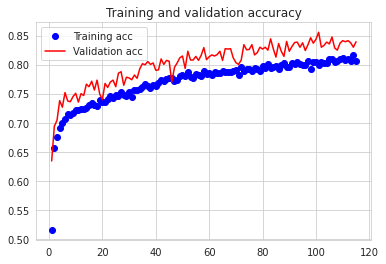

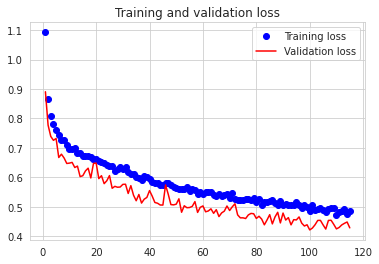

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# evaluate model
accuracy = model.evaluate(x_test_ts, y_test_ts)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

1984/1984 [==============================] - 0s 207us/step
Test set
  Loss: 0.408
  Accuracy: 0.838


In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict(x_test_ts,verbose=0)
y_pred = np.argmax(Y_pred, axis=1)
ytest=np.argmax(y_test_ts, axis=1)
print('Confusion Matrix')
matrix=confusion_matrix(ytest, y_pred)
print(confusion_matrix(ytest, y_pred))
normalize=confusion_matrix(ytest, y_pred, normalize='true')
print(normalize)
print('Classification Report')
target_names = ['CognitiveStress','EmotionalStress', 'PhysicalStress','Relax']
print(classification_report(ytest, y_pred, target_names=target_names))

Confusion Matrix
[[465  13  17  22]
 [ 77 397   6  21]
 [ 24   6 441  15]
 [ 85  28   8 359]]
[[0.89941973 0.02514507 0.03288201 0.04255319]
 [0.15369261 0.79241517 0.01197605 0.04191617]
 [0.04938272 0.01234568 0.90740741 0.0308642 ]
 [0.17708333 0.05833333 0.01666667 0.74791667]]
Classification Report
                 precision    recall  f1-score   support

CognitiveStress       0.71      0.90      0.80       517
EmotionalStress       0.89      0.79      0.84       501
 PhysicalStress       0.93      0.91      0.92       486
          Relax       0.86      0.75      0.80       480

       accuracy                           0.84      1984
      macro avg       0.85      0.84      0.84      1984
   weighted avg       0.85      0.84      0.84      1984



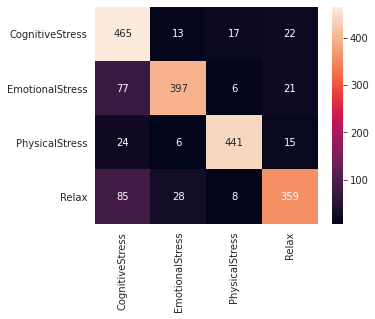

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = matrix
matrixlabel=['CognitiveStress', 'EmotionalStress','PhysicalStress','Relax']
df_cm = pd.DataFrame(array, index = matrixlabel,
                  columns = matrixlabel)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True,fmt='d')